## ML models performance
In this notebook I compare the pairs of models (Logit, LDA) and (CART, RandomForest Classifier).

First load the required packages:

In [41]:
library(dplyr)
library(ggplot2)
library(ISLR)
library(caret)
library(broom)
library(tidyr)
library(caTools)
library(MASS)
library(tree)
library(randomForest)
library(gbm)
library(rpart)
library(rpart.plot)
library(boot)
library(ranger)
library(e1071)
library(lmtest)

##some functions might be masked because of overlap from the different packages in which case they
##would be accessible via the package::function notation, i.e. using scope resolution.

### Logistic Regression versus LDA
Initial exploration of the Smarket dataset: 

In [42]:
#?Smarket
cat("dimensions of the dataset:","\n",dim(Smarket),"\n")
cat("\n")
cat("Structure of the data:","\n")
cat("\n")
str(Smarket)
cat("\n")
cat("Summary of the dataset:","\n")
cat("\n")
summary(Smarket)
cat("\n")
cat("Pearson's correlation coefficient for the numerical variables:","\n")
cor(Smarket[,-c(1,9)])
cat("\n")
cat("Check for missing values in the dataset:","\n")
gather(Smarket,key = "measure",value = "value")%>%
  group_by(measure)%>%
  summarise(sum(is.na(value)))


dimensions of the dataset: 
 1250 9 

Structure of the data: 

'data.frame':	1250 obs. of  9 variables:
 $ Year     : num  2001 2001 2001 2001 2001 ...
 $ Lag1     : num  0.381 0.959 1.032 -0.623 0.614 ...
 $ Lag2     : num  -0.192 0.381 0.959 1.032 -0.623 ...
 $ Lag3     : num  -2.624 -0.192 0.381 0.959 1.032 ...
 $ Lag4     : num  -1.055 -2.624 -0.192 0.381 0.959 ...
 $ Lag5     : num  5.01 -1.055 -2.624 -0.192 0.381 ...
 $ Volume   : num  1.19 1.3 1.41 1.28 1.21 ...
 $ Today    : num  0.959 1.032 -0.623 0.614 0.213 ...
 $ Direction: Factor w/ 2 levels "Down","Up": 2 2 1 2 2 2 1 2 2 2 ...

Summary of the dataset: 



      Year           Lag1                Lag2                Lag3          
 Min.   :2001   Min.   :-4.922000   Min.   :-4.922000   Min.   :-4.922000  
 1st Qu.:2002   1st Qu.:-0.639500   1st Qu.:-0.639500   1st Qu.:-0.640000  
 Median :2003   Median : 0.039000   Median : 0.039000   Median : 0.038500  
 Mean   :2003   Mean   : 0.003834   Mean   : 0.003919   Mean   : 0.001716  
 3rd Qu.:2004   3rd Qu.: 0.596750   3rd Qu.: 0.596750   3rd Qu.: 0.596750  
 Max.   :2005   Max.   : 5.733000   Max.   : 5.733000   Max.   : 5.733000  
      Lag4                Lag5              Volume           Today          
 Min.   :-4.922000   Min.   :-4.92200   Min.   :0.3561   Min.   :-4.922000  
 1st Qu.:-0.640000   1st Qu.:-0.64000   1st Qu.:1.2574   1st Qu.:-0.639500  
 Median : 0.038500   Median : 0.03850   Median :1.4229   Median : 0.038500  
 Mean   : 0.001636   Mean   : 0.00561   Mean   :1.4783   Mean   : 0.003138  
 3rd Qu.: 0.596750   3rd Qu.: 0.59700   3rd Qu.:1.6417   3rd Qu.: 0.596750  
 Max. 


Pearson's correlation coefficient for the numerical variables: 


,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Lag1,1.000000000,-0.026294328,-0.010803402,-0.002985911,-0.005674606,0.04090991,-0.026155045
Lag2,-0.026294328,1.000000000,-0.025896670,-0.010853533,-0.003557949,-0.04338321,-0.010250033
Lag3,-0.010803402,-0.025896670,1.000000000,-0.024051036,-0.018808338,-0.04182369,-0.002447647
Lag4,-0.002985911,-0.010853533,-0.024051036,1.000000000,-0.027083641,-0.04841425,-0.006899527
Lag5,-0.005674606,-0.003557949,-0.018808338,-0.027083641,1.000000000,-0.02200231,-0.034860083
Volume,0.040909908,-0.043383215,-0.041823686,-0.048414246,-0.022002315,1.00000000,0.014591823
Today,-0.026155045,-0.010250033,-0.002447647,-0.006899527,-0.034860083,0.01459182,1.000000000



Check for missing values in the dataset: 


Warning message:
"attributes are not identical across measure variables;
they will be dropped"

measure,sum(is.na(value))
Direction,0
Lag1,0
Lag2,0
Lag3,0
Lag4,0
Lag5,0
Today,0
Volume,0
Year,0


Pairs plot of Smarket:

Checking the types of relationships between any two variables.

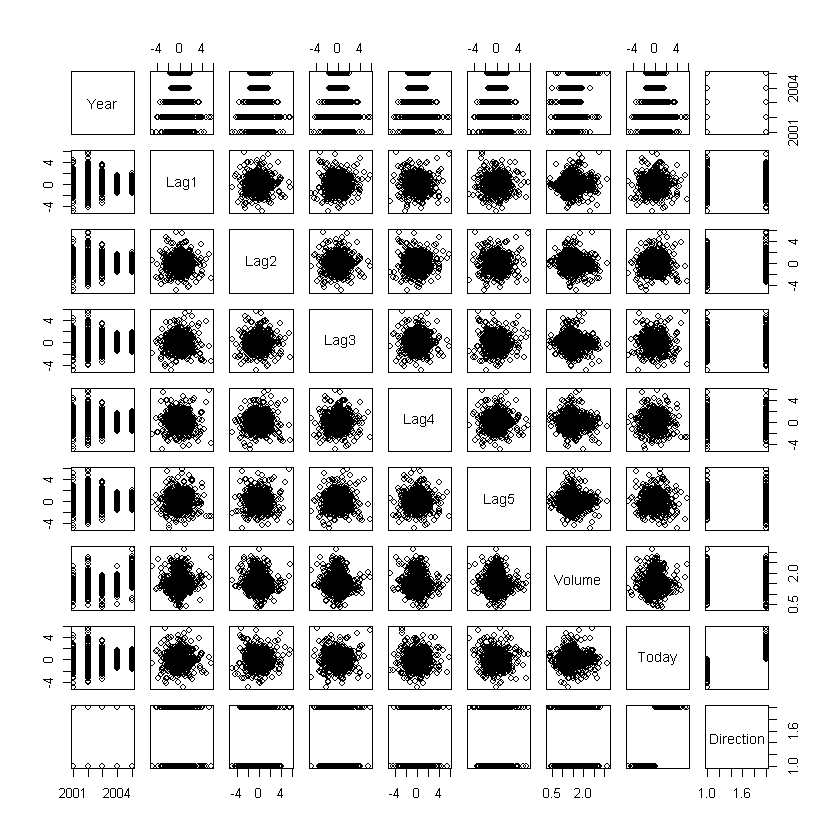

In [43]:
pairs(Smarket)

### Logistic Regression

Splitting the data and fitting a logistic regression model, train set before Year 2005, test set at Year==2005.

In [44]:
train.data<-Smarket%>%filter(Year<2005)%>%dplyr::select(-c("Year","Today"))
test.data<-Smarket%>%filter(Year==2005)%>%dplyr::select(-c("Year","Today"))
model<-glm(Direction~.,family = binomial(link="logit"),data=train.data)

Summary of the model, predicting probabilities on the test set:

summary of the model: 



Call:
glm(formula = Direction ~ ., family = binomial(link = "logit"), 
    data = train.data)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.302  -1.190   1.079   1.160   1.350  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.191213   0.333690   0.573    0.567
Lag1        -0.054178   0.051785  -1.046    0.295
Lag2        -0.045805   0.051797  -0.884    0.377
Lag3         0.007200   0.051644   0.139    0.889
Lag4         0.006441   0.051706   0.125    0.901
Lag5        -0.004223   0.051138  -0.083    0.934
Volume      -0.116257   0.239618  -0.485    0.628

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1383.3  on 997  degrees of freedom
Residual deviance: 1381.1  on 991  degrees of freedom
AIC: 1395.1

Number of Fisher Scoring iterations: 3



'data.frame':	998 obs. of  7 variables:
 $ Lag1     : num  0.381 0.959 1.032 -0.623 0.614 ...
 $ Lag2     : num  -0.192 0.381 0.959 1.032 -0.623 ...
 $ Lag3     : num  -2.624 -0.192 0.381 0.959 1.032 ...
 $ Lag4     : num  -1.055 -2.624 -0.192 0.381 0.959 ...
 $ Lag5     : num  5.01 -1.055 -2.624 -0.192 0.381 ...
 $ Volume   : num  1.19 1.3 1.41 1.28 1.21 ...
 $ Direction: Factor w/ 2 levels "Down","Up": 2 2 1 2 2 2 1 2 2 2 ...

Confusion matrix: 


Confusion Matrix and Statistics

          Reference
Prediction Down Up
      Down   77 97
      Up     34 44
                                         
               Accuracy : 0.4802         
                 95% CI : (0.417, 0.5437)
    No Information Rate : 0.5595         
    P-Value [Acc > NIR] : 0.9952         
                                         
                  Kappa : 0.0054         
                                         
 Mcnemar's Test P-Value : 6.062e-08      
                                         
            Sensitivity : 0.6937         
            Specificity : 0.3121         
         Pos Pred Value : 0.4425         
         Neg Pred Value : 0.5641         
             Prevalence : 0.4405         
         Detection Rate : 0.3056         
   Detection Prevalence : 0.6905         
      Balanced Accuracy : 0.5029         
                                         
       'Positive' Class : Down           
                                         

Down vs. Up,0.5197112


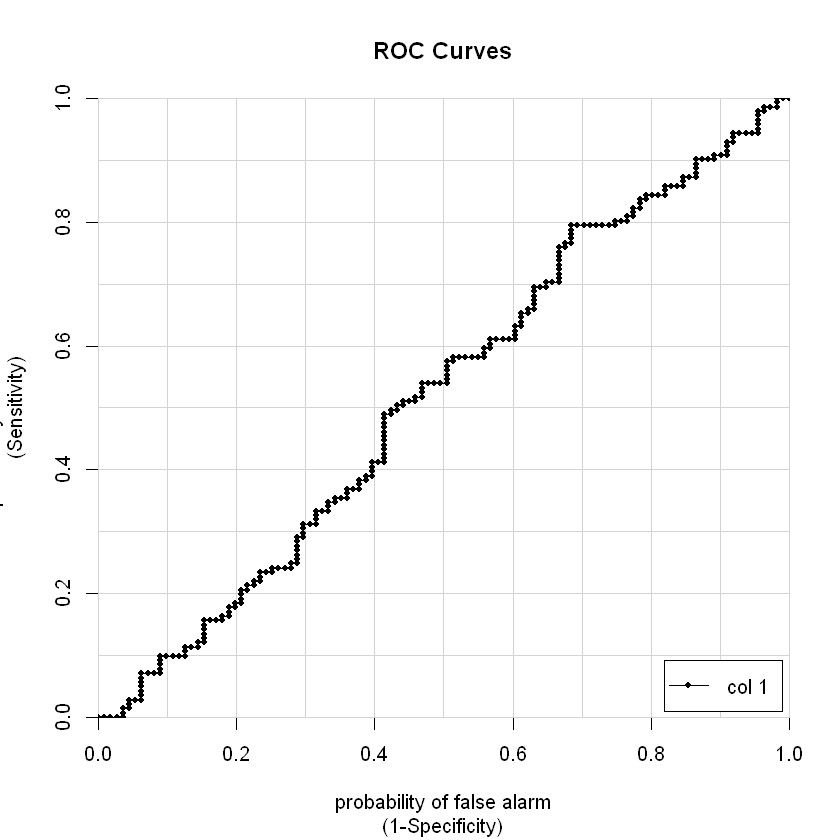

In [45]:
cat("summary of the model:","\n")
summary(model)
cat("\n")
##setting up confusion matrix
p<-predict(model,test.data,type="response")##get predicted probabilities
str(train.data)
u_or_d<-ifelse(p>0.5,"Up","Down")##set decision treshold to 0.5
##convert to class to be convenient for conf matrix function later
p_class<-factor(u_or_d,levels=levels(test.data$Direction))
cat("\n")
cat("Confusion matrix:","\n")
confusionMatrix(p_class,test.data$Direction)
cat("\n")
colAUC(p,test.data$Direction,plotROC = T)

The output of the confusion matrix indicates that the accuracy of the model is around 48% 
which is actually worse than trying to predict the direction of the market based on the
toss of a fair coin on average. Perhaps there is something wrong with the model assumptions.

Check assumptions:

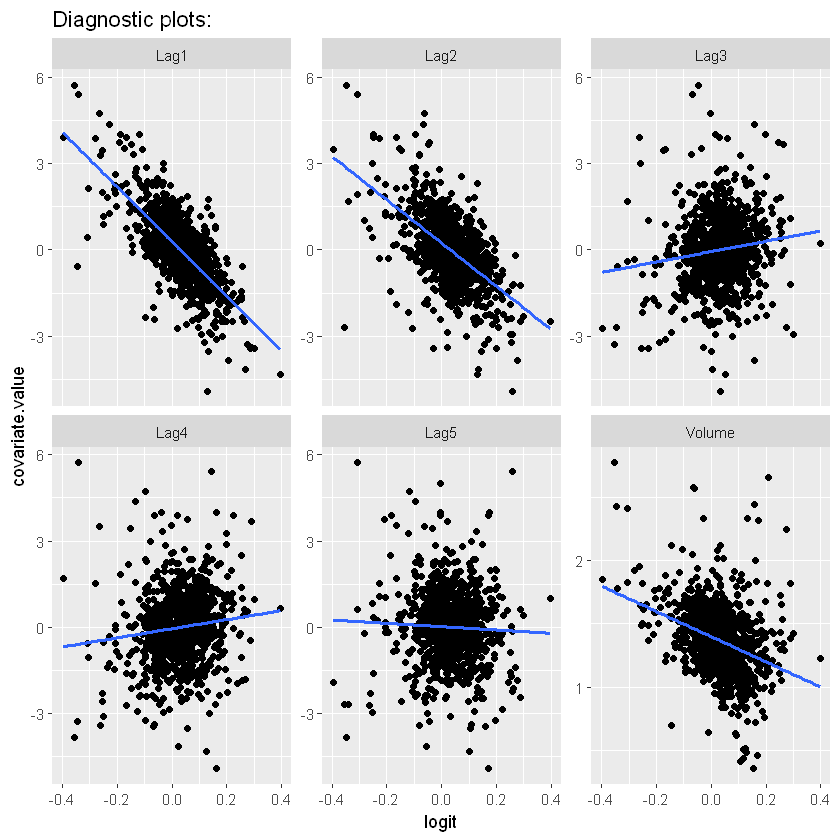

In [46]:
## 1) check for linear relationship between continuous variables and 
##the logit of the outcome i.e. log(p/(1-p))
pr_train.data<-predict(model,train.data,type="response")##predicted values
cont_pred<-train.data%>%dplyr::select(-"Direction")##extract predictors
cont_pred<-cont_pred%>%mutate(logit=log(pr_train.data/(1-pr_train.data)))%>%
  gather(key = "covariates",value="covariate.value",-logit)##add the logit to the new dataset
##check for departures via plots
ggplot(cont_pred,aes(logit,covariate.value))+geom_point()+
  geom_smooth(method = "lm",se=F)+facet_wrap(~covariates,scales = "free_y")+
    labs(title="Diagnostic plots:")

From the generated plots it is evident that only Lag1 and Lag2 have a linear relationship with the logit of the response log(p/(1-p)).

Next I check for potential influential observations using cooks distance:

indeces of outliers: 385 387 388 381 384 382 


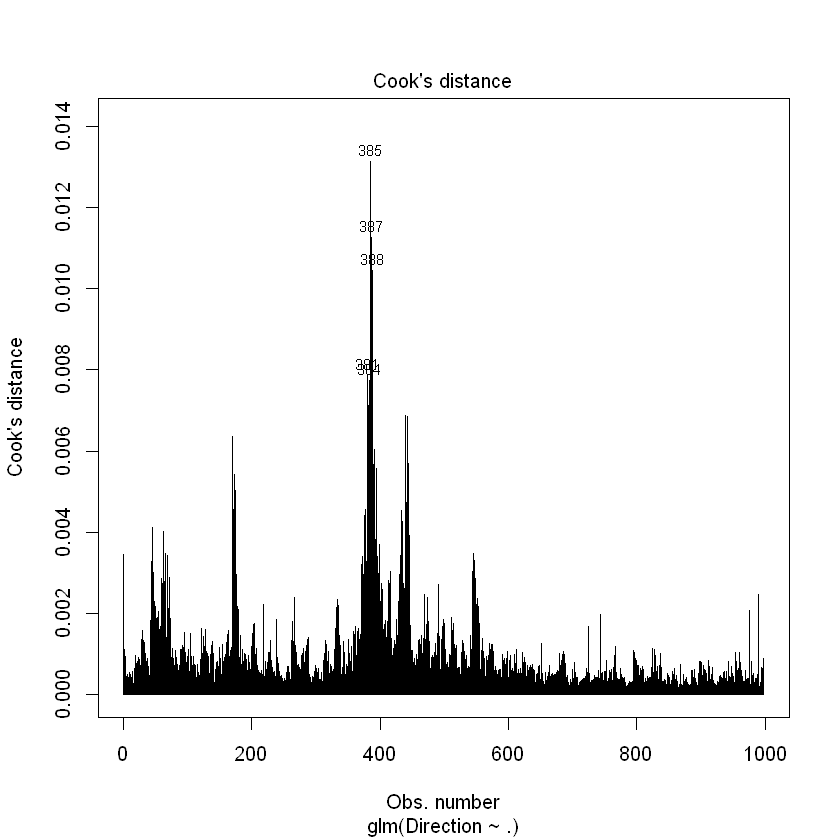

In [47]:
plot(model,which = 4,id.n = 5)##displays the five biggest extreme values
##gets the indeces of the extreme values indicated from cooks distance
extremes<-head(order(cooks.distance(model),decreasing = T))
cat("indeces of outliers:",extremes,"\n")

Next I will check for the variance inflation factors:

In [48]:
## 3) check for problems with multicollinearity with variance inflation factors
car::vif(model)

Lag1     Lag2     Lag3     Lag4     Lag5   Volume 
1.003391 1.005220 1.006023 1.008145 1.002470 1.019697

Verdict: 
I decide not to remove the outliers since those are actual events that occured and the point is to fit a model to the data and not the other way around.

The variance inflation factors seem okay as all of them are around 1.

However, from the diagnostic plots above there is clear violation of linearity and I shall try to fit a model to Lag1 and Lag2 only and then use the likelihood ratio test to see if removing all the other covariates except Lag1 and Lag2 will signifficantly change the maximum likelihood of the model.

Summary of the model 



Call:
glm(formula = Direction ~ Lag1 + Lag2, family = binomial(link = "logit"), 
    data = train.data)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.345  -1.188   1.074   1.164   1.326  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.03222    0.06338   0.508    0.611
Lag1        -0.05562    0.05171  -1.076    0.282
Lag2        -0.04449    0.05166  -0.861    0.389

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1383.3  on 997  degrees of freedom
Residual deviance: 1381.4  on 995  degrees of freedom
AIC: 1387.4

Number of Fisher Scoring iterations: 3



Likelihood ratio test: 


#Df,LogLik,Df,Chisq,Pr(>Chisq)
7,-690.5526,NA,NA,NA
3,-690.7010,-4,0.2968941,0.9900138


Confusion Matrix and Statistics

          Reference
Prediction Down  Up
      Down   35  35
      Up     76 106
                                          
               Accuracy : 0.5595          
                 95% CI : (0.4959, 0.6218)
    No Information Rate : 0.5595          
    P-Value [Acc > NIR] : 0.5262856       
                                          
                  Kappa : 0.0698          
                                          
 Mcnemar's Test P-Value : 0.0001467       
                                          
            Sensitivity : 0.3153          
            Specificity : 0.7518          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 0.5824          
             Prevalence : 0.4405          
         Detection Rate : 0.1389          
   Detection Prevalence : 0.2778          
      Balanced Accuracy : 0.5335          
                                          
       'Positive' Class : Down            
                           

Down vs. Up,0.5584308


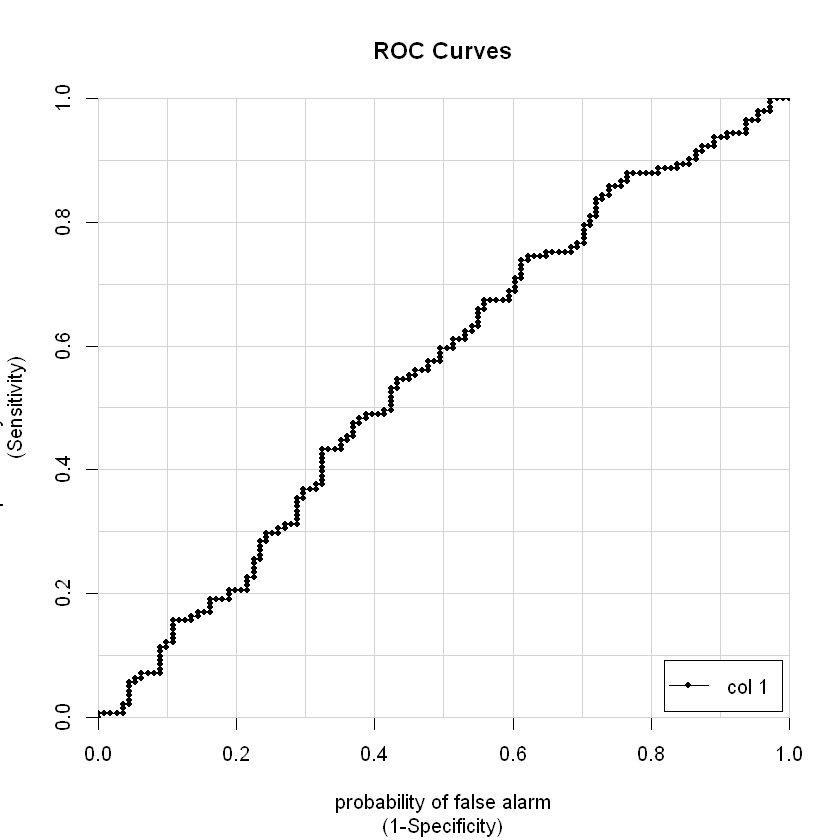

In [49]:
mdl<-glm(Direction~Lag1+Lag2,family = "binomial"(link = "logit"),data = train.data)
cat("Summary of the model", "\n")
summary(mdl)
cat("\n")
cat("Likelihood ratio test:","\n")
lrtest(model,mdl)
cat("\n")
pr_test<-predict(mdl,test.data,type = "response")
up_or_down<-ifelse(pr_test>0.5,"Up","Down")
pr_class<-factor(up_or_down,levels = levels(test.data$Direction))
conf_mat_log<-confusionMatrix(pr_class,test.data$Direction)
conf_mat_log
colAUC(pr_test,test.data$Direction,plotROC = T)

Based on the LR test comparing the full model and the restricted model with only Lag1 and Lag2 as covariates, the test failed to reject the null hypothesis that the other covariates are statistically insignificant.

Furthermore, the new model (on Lag1 and Lag2) actually gives a slightly better accuracy than the full model. The accuracy of the former is 0.56 while it was 0.48 for the latter. The initial model (the full model) performed worse than trying to guess the direction of the market based on the toss of a fair coin (50% chance of getting it right).

### Linear Discriminant Analysis:

Fit an LDA model to predict the values of the direction of the stock market based on Lag1 and Lag2 only.

Call:
lda(Direction ~ Lag1 + Lag2, data = train.data)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

Coefficients of linear discriminants:
            LD1
Lag1 -0.6420190
Lag2 -0.5135293

Look at the attributes of the model object 


$names
[1] "class"     "posterior" "x"


Get the first 6 values of the posterior probabilities: 


Down,Up
0.4901792,0.5098208
0.4792185,0.5207815
0.4668185,0.5331815
0.4740011,0.5259989
0.4927877,0.5072123
0.4938562,0.5061438


Confusion Matrix and Statistics

          Reference
Prediction Down  Up
      Down   35  35
      Up     76 106
                                          
               Accuracy : 0.5595          
                 95% CI : (0.4959, 0.6218)
    No Information Rate : 0.5595          
    P-Value [Acc > NIR] : 0.5262856       
                                          
                  Kappa : 0.0698          
                                          
 Mcnemar's Test P-Value : 0.0001467       
                                          
            Sensitivity : 0.3153          
            Specificity : 0.7518          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 0.5824          
             Prevalence : 0.4405          
         Detection Rate : 0.1389          
   Detection Prevalence : 0.2778          
      Balanced Accuracy : 0.5335          
                                          
       'Positive' Class : Down            
                           

,Down,Up
Down vs. Up,0.5584308,0.5584308


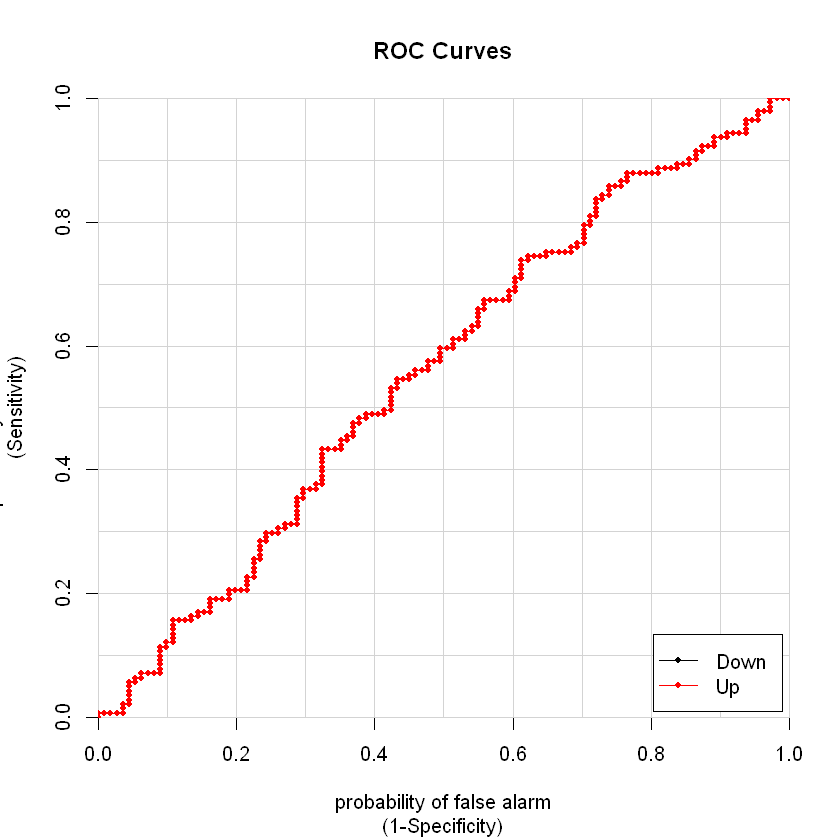

In [50]:
model_lda<-lda(Direction~Lag1+Lag2,data=train.data)##assign a model
print(model_lda)##print the call of the model
pred_lda<-predict(model_lda,test.data)##predict on test data
cat("\n")
cat("Look at the attributes of the model object","\n")
attributes(pred_lda)##look at the components of the object
cat("\n")
cat("Get the first 6 values of the posterior probabilities:","\n")
head(pred_lda$posterior)##look at the first 6 rows in the posterior matrix
cat("\n")
conf_mat_lda<-confusionMatrix(pred_lda$class,test.data$Direction)##confusion matrix
conf_mat_lda
cat("\n")
colAUC(pred_lda$posterior,test.data$Direction,plotROC = T)

Based on the accuracy metric this model performed the same as the Logistic Regression model (accuracy=0.56 see confusion matrix output).

Check model assumptions (in class normality of predictors and similar in class varcov matrices): 


varcov matrices in the different classes: 


,Lag1,Lag2
Lag1,1.51700576,-0.02787349
Lag2,-0.02787349,1.49026815


,Lag1,Lag2
Lag1,1.50662277,-0.03924806
Lag2,-0.03924806,1.53559498


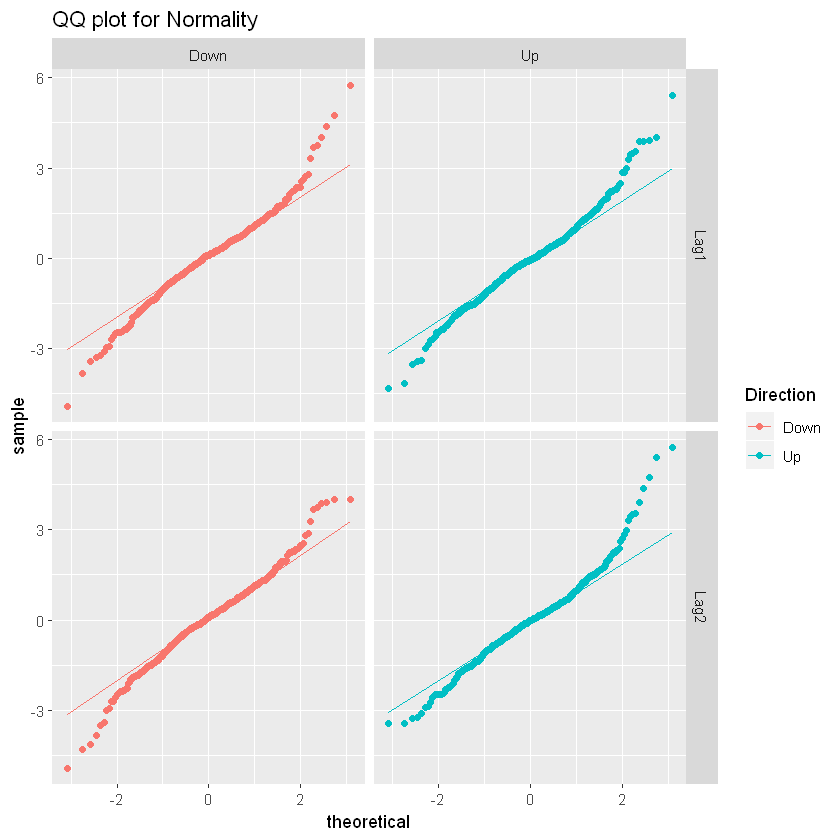

In [51]:
gaus_check<-gather(train.data,key = "lag",value = "percent",c(1,2))
ggplot(gaus_check,aes(sample=percent,col=Direction))+stat_qq()+
  stat_qq_line()+facet_grid(rows = vars(lag),cols = vars(Direction))+
  labs(title = "QQ plot for Normality")
cat("\n")
cat("varcov matrices in the different classes:", "\n")
varcov_up<-cov(train.data%>%filter(Direction=="Up")%>%dplyr::select(Lag1,Lag2))
varcov_down<-cov(train.data%>%filter(Direction=="Down")%>%dplyr::select(Lag1,Lag2))
varcov_up
varcov_down

There are some apparent departures from the in-class normality assumption of the predictors as can be seen from the normal qq-plots above. Furthermore, the variance covariance matrices are different as well inside the different classes ("Up" or "Down").

In [52]:
conf_mat_lda##confusion matrix for the lda model
conf_mat_log##confussion matrix for the logit model with Lag1 and Lag2

Confusion Matrix and Statistics

          Reference
Prediction Down  Up
      Down   35  35
      Up     76 106
                                          
               Accuracy : 0.5595          
                 95% CI : (0.4959, 0.6218)
    No Information Rate : 0.5595          
    P-Value [Acc > NIR] : 0.5262856       
                                          
                  Kappa : 0.0698          
                                          
 Mcnemar's Test P-Value : 0.0001467       
                                          
            Sensitivity : 0.3153          
            Specificity : 0.7518          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 0.5824          
             Prevalence : 0.4405          
         Detection Rate : 0.1389          
   Detection Prevalence : 0.2778          
      Balanced Accuracy : 0.5335          
                                          
       'Positive' Class : Down            
                           

Confusion Matrix and Statistics

          Reference
Prediction Down  Up
      Down   35  35
      Up     76 106
                                          
               Accuracy : 0.5595          
                 95% CI : (0.4959, 0.6218)
    No Information Rate : 0.5595          
    P-Value [Acc > NIR] : 0.5262856       
                                          
                  Kappa : 0.0698          
                                          
 Mcnemar's Test P-Value : 0.0001467       
                                          
            Sensitivity : 0.3153          
            Specificity : 0.7518          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 0.5824          
             Prevalence : 0.4405          
         Detection Rate : 0.1389          
   Detection Prevalence : 0.2778          
      Balanced Accuracy : 0.5335          
                                          
       'Positive' Class : Down            
                           

Summary:
It seems that both models performed similarly when only lag1 and lag2 were the predictors. Both achieved accuracy of 56% which is slightly better than the alternative of tossing a coin (50% chance of guessing the direction).
When checking for departures from assumptions, it seems that there is a violation of the normality assumption for the predictors in the different classes for the lda model. The covariance matrices were also different for the different classes so perhaps the lda was not the most appropriate model for this job. The logistic regression model, on the other hand, does not need the assumption of normality of the predictors in the different classes and in this case actually seems to be more appropriate to be used. The coefficients for the logistic regression are estimated by maximum likelihood so they are more robust to non-normality in the covariates in the diferent classes. If I had to choose one or the other in this case I would choose the logistic regression model since there were no clear departures from assumptions when it came to regressing direction on just Lag1 and Lag2.
The lda is typically more likely to perform better than the logit model if there were more groups for classification, that is, if the assumptions for the model are met, nevertheless.

## Classifiacation Tree vs Random Forest Classifier:

Initial exploration of the Carseats dataset:

In [53]:
cat("Summary of the Carseats dataset:","\n")
summary(Carseats)
##Creating and adding the "High" variable to the dataset
Carseats_new<-Carseats%>%mutate(High=ifelse(Sales<=8,"No","Yes"))
Carseats_new<-as.tbl(Carseats_new)
cat("\n")
cat("\n")
cat("Look at the structure of the dataset","\n")
cat("\n")
str(Carseats_new)
##converting the "High" variable to a factor with levels "Yes" or "No"
Carseats_new$High<-factor(Carseats_new$High,levels = c("Yes","No"))

Summary of the Carseats dataset: 


     Sales          CompPrice       Income        Advertising    
 Min.   : 0.000   Min.   : 77   Min.   : 21.00   Min.   : 0.000  
 1st Qu.: 5.390   1st Qu.:115   1st Qu.: 42.75   1st Qu.: 0.000  
 Median : 7.490   Median :125   Median : 69.00   Median : 5.000  
 Mean   : 7.496   Mean   :125   Mean   : 68.66   Mean   : 6.635  
 3rd Qu.: 9.320   3rd Qu.:135   3rd Qu.: 91.00   3rd Qu.:12.000  
 Max.   :16.270   Max.   :175   Max.   :120.00   Max.   :29.000  
   Population        Price        ShelveLoc        Age          Education   
 Min.   : 10.0   Min.   : 24.0   Bad   : 96   Min.   :25.00   Min.   :10.0  
 1st Qu.:139.0   1st Qu.:100.0   Good  : 85   1st Qu.:39.75   1st Qu.:12.0  
 Median :272.0   Median :117.0   Medium:219   Median :54.50   Median :14.0  
 Mean   :264.8   Mean   :115.8                Mean   :53.32   Mean   :13.9  
 3rd Qu.:398.5   3rd Qu.:131.0                3rd Qu.:66.00   3rd Qu.:16.0  
 Max.   :509.0   Max.   :191.0                Max.   :80.00   Max.   :18.0  



Look at the structure of the dataset 

Classes 'tbl_df', 'tbl' and 'data.frame':	400 obs. of  12 variables:
 $ Sales      : num  9.5 11.22 10.06 7.4 4.15 ...
 $ CompPrice  : num  138 111 113 117 141 124 115 136 132 132 ...
 $ Income     : num  73 48 35 100 64 113 105 81 110 113 ...
 $ Advertising: num  11 16 10 4 3 13 0 15 0 0 ...
 $ Population : num  276 260 269 466 340 501 45 425 108 131 ...
 $ Price      : num  120 83 80 97 128 72 108 120 124 124 ...
 $ ShelveLoc  : Factor w/ 3 levels "Bad","Good","Medium": 1 2 3 3 1 1 3 2 3 3 ...
 $ Age        : num  42 65 59 55 38 78 71 67 76 76 ...
 $ Education  : num  17 10 12 14 13 16 15 10 10 17 ...
 $ Urban      : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 1 2 2 1 1 ...
 $ US         : Factor w/ 2 levels "No","Yes": 2 2 2 2 1 2 1 2 1 2 ...
 $ High       : chr  "Yes" "Yes" "Yes" "No" ...


### Classification Tree

Building classification tree model on the entire dataset without parameter tuning

In [54]:
##model on full dataset with no parameter tuning
model_tree<-tree(High~.-Sales,data = Carseats_new)
confusionMatrix(predict(model_tree,Carseats_new,type = "class"),Carseats_new$High)
## terminal nodes are 27, error rate is 0.09, see in output from summary
cat("\n")
cat("Summary of the model:","\n")
cat("\n")
summary(model_tree)

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes 151  23
       No   13 213
                                          
               Accuracy : 0.91            
                 95% CI : (0.8776, 0.9362)
    No Information Rate : 0.59            
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8157          
                                          
 Mcnemar's Test P-Value : 0.1336          
                                          
            Sensitivity : 0.9207          
            Specificity : 0.9025          
         Pos Pred Value : 0.8678          
         Neg Pred Value : 0.9425          
             Prevalence : 0.4100          
         Detection Rate : 0.3775          
   Detection Prevalence : 0.4350          
      Balanced Accuracy : 0.9116          
                                          
       'Positive' Class : Yes             
                              


Summary of the model: 




Classification tree:
tree(formula = High ~ . - Sales, data = Carseats_new)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "US"          "Income"      "CompPrice"  
[6] "Population"  "Advertising" "Age"        
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

Now build an optimised model:

In [55]:
##split data into training and test data
##set seed for pseudo random sampling
set.seed(111)
train_indeces<-sample(nrow(Carseats_new),round(nrow(Carseats_new)*0.8))
train_carseats<-Carseats_new[train_indeces,-1]
test_carseats<-Carseats_new[-train_indeces,-1]

In [56]:
##Build an optimal model through cross-validation and caret package
##Create train control argument to pass into train(), set to 10-fold cv
##with 4 repeats and set the criteria to be the AUC (area under the ROC curve) metric
mycontrol<-trainControl(method = "repeatedcv",number = 10,repeats = 4,
                        summaryFunction = twoClassSummary, 
                        classProbs = T)
##Create tune grid for maxdepth of the tree 
tuning<-expand.grid(maxdepth = 2:14)
##pass on the created 2 arguments to the train() function from {caret}
##set seed so that we get similar samples from cross validation
set.seed(12)
new_tree<-train(High~.,data = train_carseats,method="rpart2",tuneGrid=tuning,
                trControl=mycontrol,metric="ROC")

Get model characteristic and run some plots:

Get the best tune of maxdepth parameter: 


,maxdepth
8,9



Call the best model: 


n= 320 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 320 126 No (0.39375000 0.60625000)  
    2) ShelveLocGood>=0.5 65  15 Yes (0.76923077 0.23076923)  
      4) Price< 142.5 56   8 Yes (0.85714286 0.14285714) *
      5) Price>=142.5 9   2 No (0.22222222 0.77777778) *
    3) ShelveLocGood< 0.5 255  76 No (0.29803922 0.70196078)  
      6) Price< 88 24   4 Yes (0.83333333 0.16666667) *
      7) Price>=88 231  56 No (0.24242424 0.75757576)  
       14) Advertising>=13.5 40  17 Yes (0.57500000 0.42500000)  
         28) Income>=99.5 10   0 Yes (1.00000000 0.00000000) *
         29) Income< 99.5 30  13 No (0.43333333 0.56666667)  
           58) CompPrice>=131.5 10   1 Yes (0.90000000 0.10000000) *
           59) CompPrice< 131.5 20   4 No (0.20000000 0.80000000) *
       15) Advertising< 13.5 191  33 No (0.17277487 0.82722513)  
         30) CompPrice>=124.5 107  28 No (0.26168224 0.73831776)  
           60) Price< 109.5 18   6 Yes (0.66666667 0.33333333

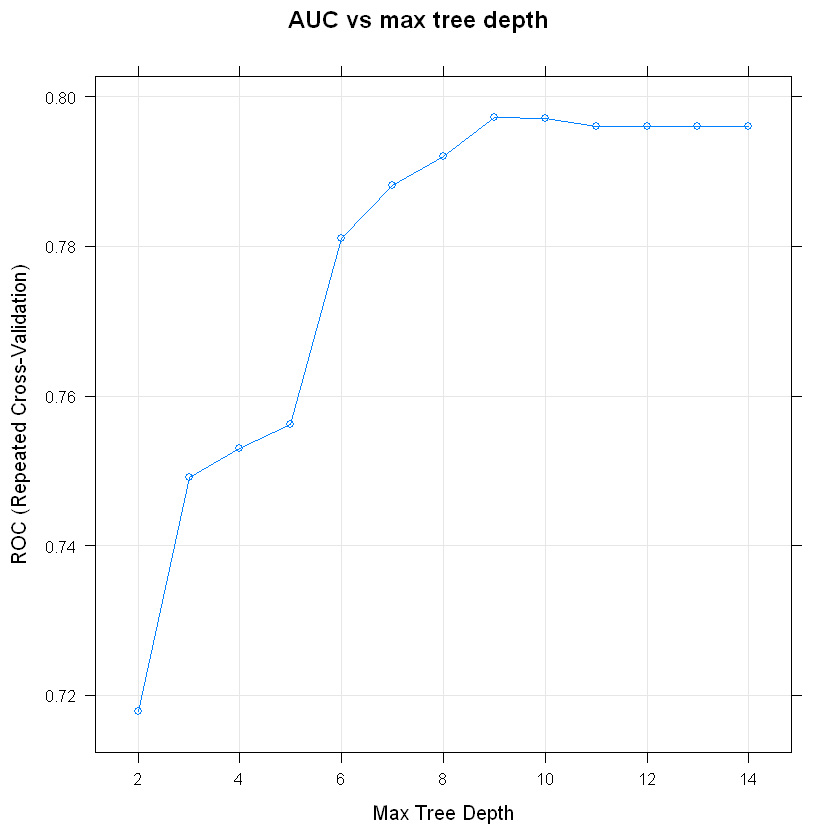

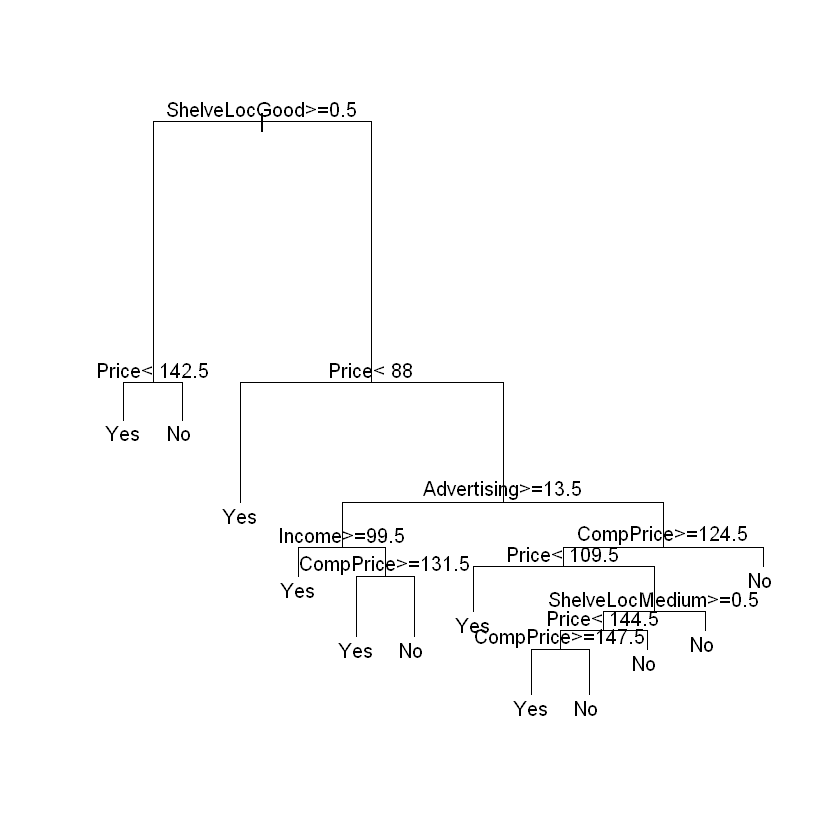

In [57]:
cat("Get the best tune of maxdepth parameter:","\n")
new_tree$bestTune
cat("\n")
cat("Call the best model:","\n")
new_tree$finalModel
##plot to see visually where the optimal maxdepth is for max AUC 
plot(new_tree,main="AUC vs max tree depth")
##plot the classification tree
par(xpd=T)
plot(new_tree$finalModel)
text(new_tree$finalModel,digits = 1)

Number of terminal nodes from the final model: 


[1] 12

Confusion Matrix and Statistics

          Reference
Prediction Yes No
       Yes  26  9
       No   12 33
                                          
               Accuracy : 0.7375          
                 95% CI : (0.6271, 0.8296)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 8.076e-05       
                                          
                  Kappa : 0.4717          
                                          
 Mcnemar's Test P-Value : 0.6625          
                                          
            Sensitivity : 0.6842          
            Specificity : 0.7857          
         Pos Pred Value : 0.7429          
         Neg Pred Value : 0.7333          
             Prevalence : 0.4750          
         Detection Rate : 0.3250          
   Detection Prevalence : 0.4375          
      Balanced Accuracy : 0.7350          
                                          
       'Positive' Class : Yes             
                                 

Error from final model: 


[1] 0.2625


Important variables: 


rpart2 variable importance

                Overall
Price           100.000
ShelveLocGood    73.483
CompPrice        50.767
Advertising      34.191
Income           15.389
ShelveLocMedium   7.585
USYes             0.000
Population        0.000
Age               0.000
Education         0.000
UrbanYes          0.000

,Yes,No
Yes vs. No,0.7603383,0.7603383


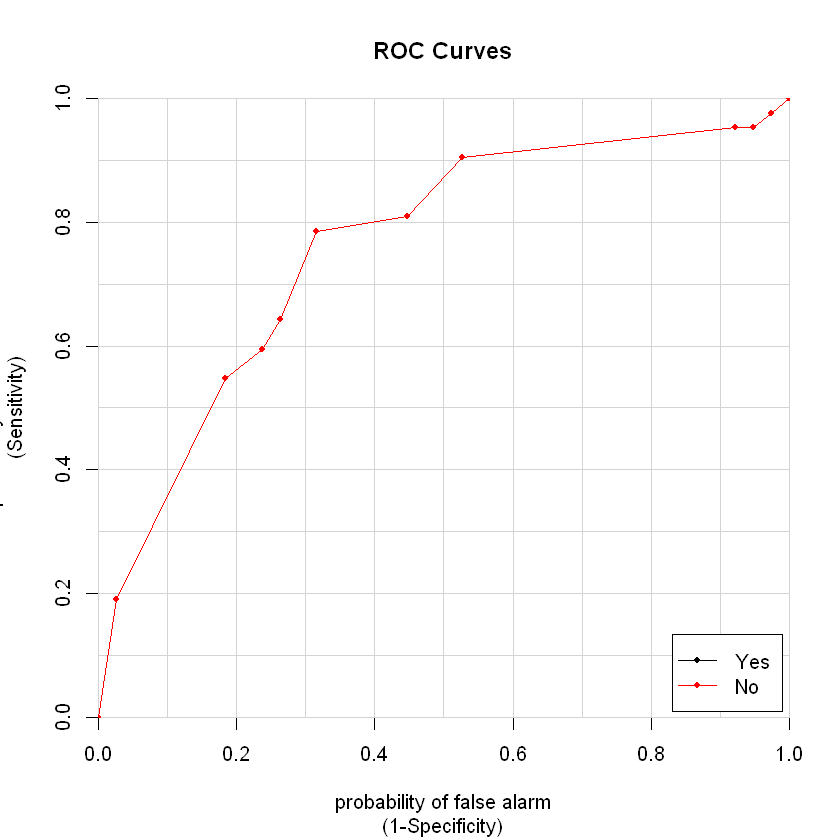

In [58]:
##get the number of terminal nodes from the final model, they are 12
cat("Number of terminal nodes from the final model:","\n")
sum(new_tree$finalModel$frame$var=="<leaf>")
cat("\n")
##get "raw" predictions and use them for the confusionmatrix
pred_tree<-predict(new_tree,test_carseats,type = "raw")
##confusion matrix
confusionMatrix(pred_tree,test_carseats$High)
##get the error rate from the final model,
##calculate as 1-accuracy from the confusion matrix
cat("Error from final model:", "\n")
1-confusionMatrix(pred_tree,test_carseats$High)$overall[[1]]
##get the important variables
cat("\n")
cat("Important variables:","\n")
varImp(new_tree,compete=F,surrogates=F)
##get probability predictions for the ROC plot
pred_tree_prob<-predict(new_tree,test_carseats,type = "prob")
par(xpd=F)
##plot the ROC curve
colAUC(pred_tree_prob,test_carseats$High,plotROC = T)

### Random Forest

In [59]:
##make custom train control according to area under the ROC curve
rf_control<-trainControl(method = "cv",number = 10,
                         summaryFunction = twoClassSummary,
                         classProbs = T)
##create custom tune grid for the mtry parameter
mytune<-data.frame(.mtry=3:8,.splitrule="gini",.min.node.size=5)
##set seed for pseudo random sampling
set.seed(111)
##I used the ranger method here since it is faster than the rf
model_rf<-train(High~.,data = train_carseats,method="ranger",
                tuneGrid=mytune,trControl=rf_control,importance="impurity")

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

I used the "ranger" method since it is faster than the "rf" method. 
Get some metrics of the model:

Get the best tune of the model: 


,mtry,splitrule,min.node.size
3,5,gini,5



Call final model: 


Ranger result

Call:
 ranger::ranger(dependent.variable.name = ".outcome", data = x,      mtry = min(param$mtry, ncol(x)), min.node.size = param$min.node.size,      splitrule = as.character(param$splitrule), write.forest = TRUE,      probability = classProbs, ...) 

Type:                             Probability estimation 
Number of trees:                  500 
Sample size:                      320 
Number of independent variables:  11 
Mtry:                             5 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.1357428 


 OOB Prediction error: 


[1] 0.1357428



Variable importance: 


ranger variable importance

                Overall
Price           100.000
ShelveLocGood    50.263
Advertising      46.051
CompPrice        41.002
Age              34.316
Income           31.902
Population       25.162
Education        12.098
ShelveLocMedium   7.831
USYes             3.150
UrbanYes          0.000

Confusion Matrix and Statistics

          Reference
Prediction Yes No
       Yes  24  4
       No   14 38
                                          
               Accuracy : 0.775           
                 95% CI : (0.6679, 0.8609)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 3.466e-06       
                                          
                  Kappa : 0.5431          
                                          
 Mcnemar's Test P-Value : 0.03389         
                                          
            Sensitivity : 0.6316          
            Specificity : 0.9048          
         Pos Pred Value : 0.8571          
         Neg Pred Value : 0.7308          
             Prevalence : 0.4750          
         Detection Rate : 0.3000          
   Detection Prevalence : 0.3500          
      Balanced Accuracy : 0.7682          
                                          
       'Positive' Class : Yes             
                                 

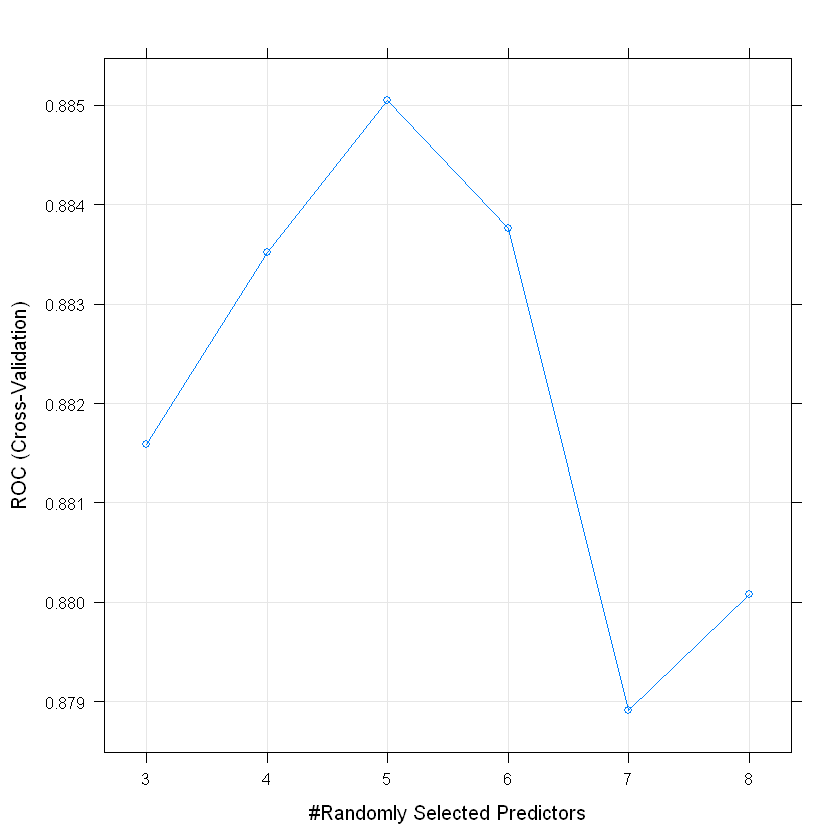

,Yes,No
Yes vs. No,0.8953634,0.8953634


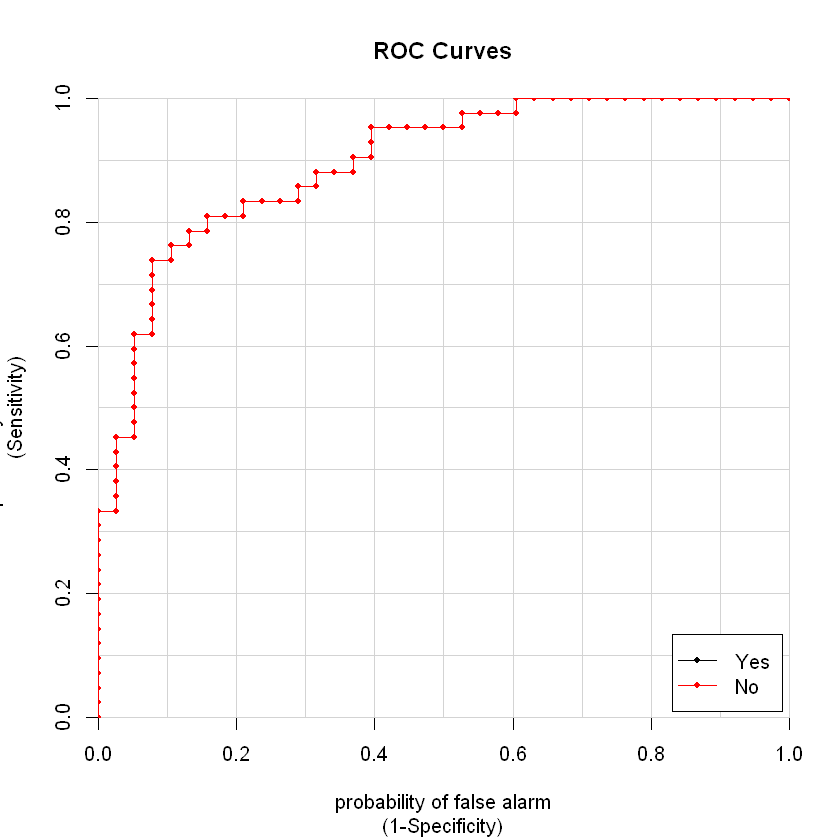

In [60]:
cat("Get the best tune of the model:","\n")
model_rf$bestTune##call best tune
cat("\n")
cat("Call final model:","\n")
model_rf$finalModel##call final model
##get the OOB prediction error
cat("\n")
cat(" OOB Prediction error:","\n")
model_rf$finalModel$prediction.error
##get a visual representation of the 
cat("\n")
plot(model_rf)
##show the important variables
cat("\n")
cat("Variable importance:","\n")
varImp(model_rf)
cat("\n")
##get the prediction as labels for the confusion matrix
pred_rf<-predict(model_rf,test_carseats,type = "raw")
##calculate the confusion matrix
confusionMatrix(pred_rf,test_carseats$High)
##get the predictions in probability form for the ROC plot
pred_rf_prob<-predict(model_rf,test_carseats,type = "prob")
cat("\n")
##plot the ROC curve
colAUC(pred_rf_prob,test_carseats$High,plotROC = T)

Summary:

The out of bag prediction error rate of the Random Forest model is two times lower than that of the classification tree (0.13 and 0.26 respectively). The accuracy of the Random Forest model is also higher than that of the classification tree. The validity of the previous statement is evident both from the ROC plots and the outputs from the confusion matrices. The accuracy of the Random Forest model is 0.775 while the accuracy of the classification tree is 0.7375. Both models, however, returned similar outputs for the variable importance, price and shelve local good taking the first places.

The advantage of the classification tree is the ease of interpretation of the model. The disadvantage is that in general single trees tend to overfit and are not as good when evaluating their performance on the test set.

The advantage of the Random Forest method is the low out of bag error rate and the higher accuracy in comparison to the classification tree. The disadvantage of the model is that the model is more difficult to interpret. And of course if the actual decision boundary is linear then both models (CART and RF) will perform worse than some classifier with linear decision boundary e.g. logit. Furthermore, if the RF has very few relevant variables and many noise variables and the number of variables selected at each split m is small, then the RF will perform poorly, since there will be a smaller probability of a relevant variable to be chosen among the m variables for the split.